# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [9]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [11]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что алгоритм выдает вероятность принадлежности к классу, поэтому чтобы получить истинную метку надо взять определенное пороговое значение и сравнивать вероятность с ним. В зависимости от этого мы сможем получить метку класса

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [12]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


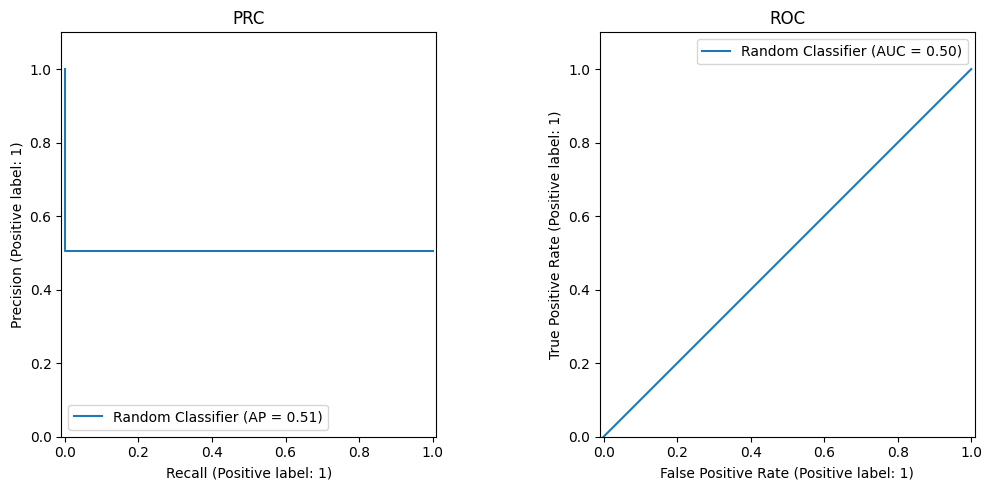

In [13]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [14]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [15]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

best_C, best_auc, best_svm = None, -100500, None

for C in np.logspace(-3, 3, 20):
    svm = LinearSVC(C=C)
    svm.fit(X_train, y_train)

    y_pred = svm.decision_function(X_val)
    auc = average_precision_score(y_val, y_pred)

    if auc > best_auc:
        best_C = C
        best_auc = auc
        best_svm = svm

print(f"C = {best_C}")

C = 0.3359818286283781


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM metrics
AUC-PR: 0.8300
AUC-ROC: 0.8476


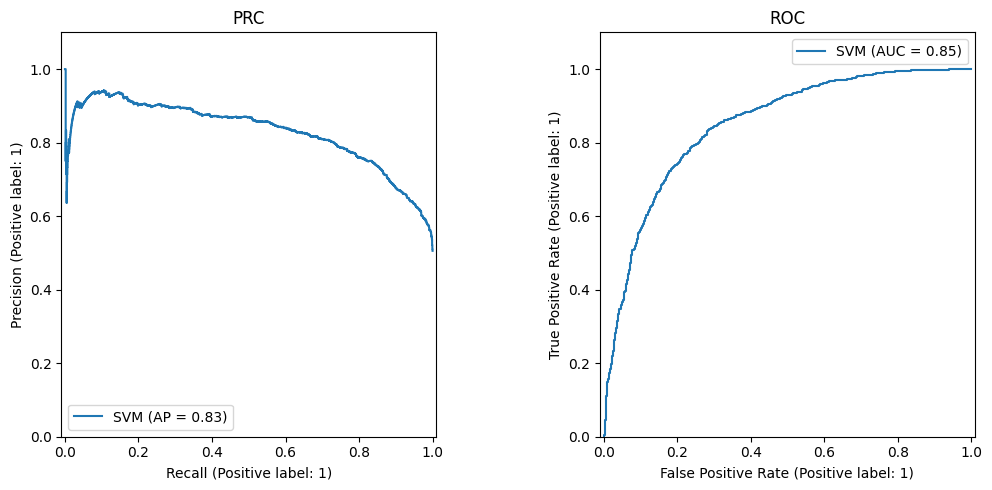

In [16]:
y_svm = best_svm.decision_function(X_test)
depict_pr_roc(y_test, y_svm, 'SVM')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

На PRC графике виден скачок при threshold близким к 1. Это связано с тем, что модель уверена, что у некоторых объектов с меткой -1 правильный ответ 1. 
Так же это ситуация видна на ROC графике, когда не наблюдается быстрого вертикального слева, ведь по хорошему вначале должен быть резкий рост TPR (если предсказанная вероятность близка к 1, то и метка должна быть 1). 
ROC график всегда будет монотонным, чего нельзя сказать про PR

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [17]:
df_metrics.loc['svm'] = [
    average_precision_score(y_test, y_svm),
    roc_auc_score(y_test, y_svm),
    best_C,
]

In [18]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
svm,0.829952,0.847648,0.335982


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [19]:
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

best_C, best_auc, best_linreg = None, -100500, None

for C in np.logspace(-3, 3, 20):
    linreg = LogisticRegression(C=C)
    linreg.fit(X_train, y_train)

    y_pred = linreg.decision_function(X_val)
    auc = average_precision_score(y_val, y_pred)

    if auc > best_auc:
        best_C = C
        best_auc = auc
        best_linreg = linreg

print(f"C = {best_C}")

C = 0.001


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression metrics
AUC-PR: 0.8338
AUC-ROC: 0.8453
SVM metrics
AUC-PR: 0.8300
AUC-ROC: 0.8476
Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


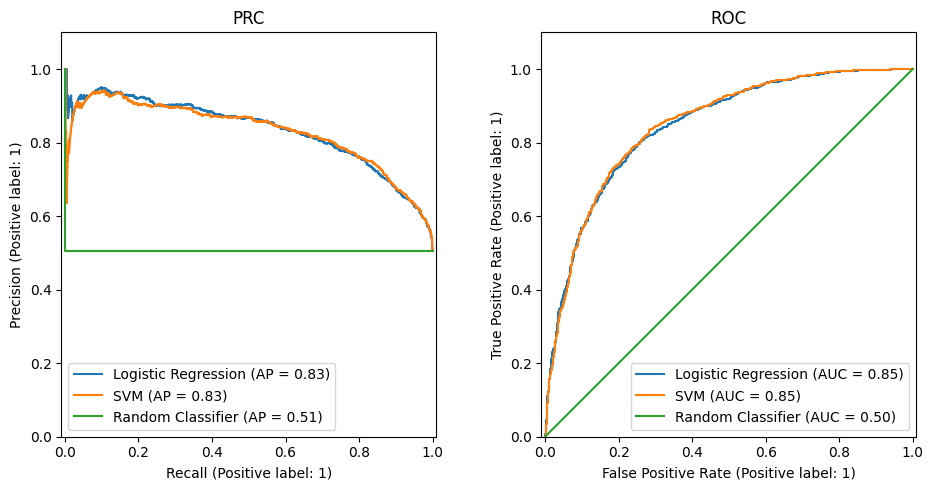

In [20]:
y_linreg = best_linreg.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

depict_pr_roc(y_test, y_linreg, 'Logistic Regression', ax)
depict_pr_roc(y_test, y_svm, 'SVM', ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)

In [21]:
df_metrics.loc['linreg'] = [
    average_precision_score(y_test, y_linreg),
    roc_auc_score(y_test, y_linreg),
    best_C,
]

In [22]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
svm,0.829952,0.847648,0.335982
linreg,0.833757,0.845335,0.001000


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Значения метрик вышли очень похожими, можно считать что различий нет

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [23]:
from sklearn.svm import SVC

X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)
svm = SVC(kernel="linear")
svm.fit(X, y)

SVC(kernel='linear')

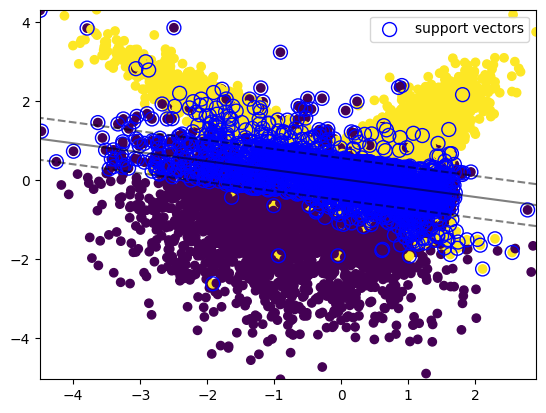

In [24]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        x=X[:, 0], 
        y=X[:, 1], 
        c=y,
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, svm)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** ожидаемо опорные вектора - элементы наиболее близкие к разделяющей прямой

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [25]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

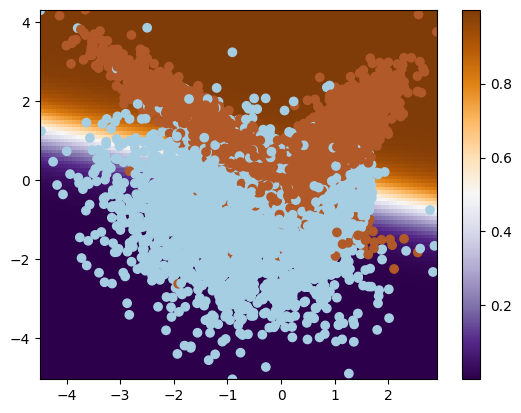

In [26]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        x=X[:, 0], 
        y=X[:, 1], 
        c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** эта область на картинка изображена белым цветом, как раз в районе вероятности 0.5. Если вероятность равна примерно 0.5, значит скалярное произведение весов и признаков равно примерно 0. Таким образом это прямая, разделяющая плоскость на две части

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [27]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


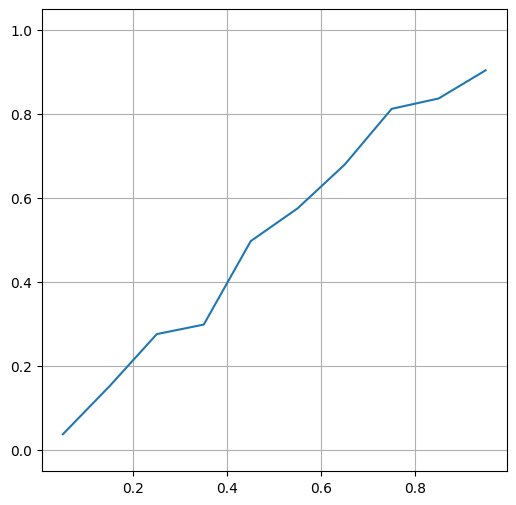

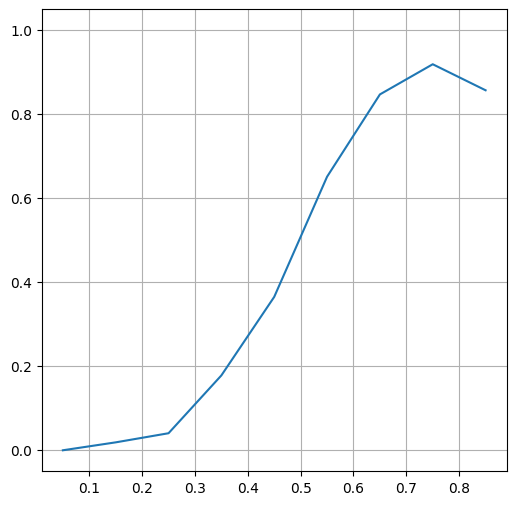

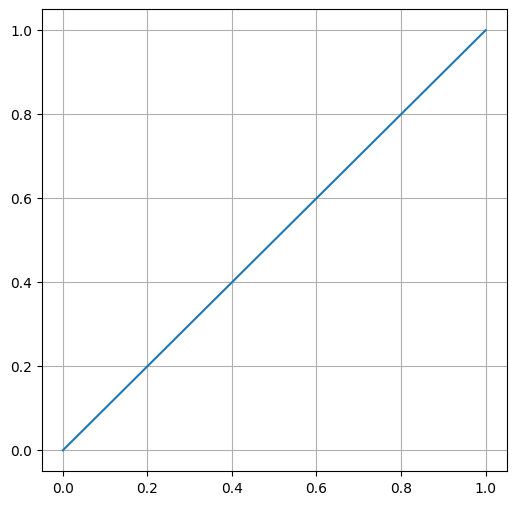

In [28]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_logreg = logreg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_logreg)

svm = LinearSVC()
svm.fit(X_train, y_train)
y_svm = 1 / (1 + np.exp(-svm.decision_function(X_test)))
plot_calibration_curve(y_test, y_svm)

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1])
plt.ylim([-0.05, 1.05])
plt.grid()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Видно, что кривая для лог. регрессии намного больше похоже на диагональную

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [29]:
from sklearn.metrics import log_loss, brier_score_loss

print(f"log_reg: log_loss = {log_loss(y_test, y_logreg)}, brier_score = {brier_score_loss(y_test, y_logreg)}")
print(f"svm: log_loss = {log_loss(y_test, y_svm)}, brier_score = {brier_score_loss(y_test, y_svm)}")

log_reg: log_loss = 0.4858556295167715, brier_score = 0.15858348672613165
svm: log_loss = 0.5520712135729844, brier_score = 0.18316547688479232


Логрег опять показал себя лучше, чем свм

Изучите распределение ответов классификаторов при помощи гистограмм

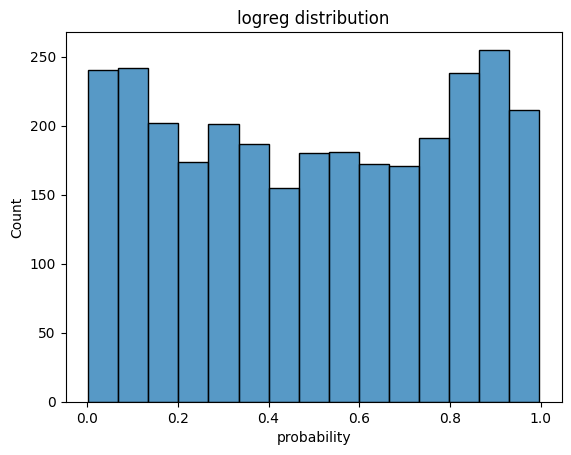

In [30]:
import seaborn as sns

plt.title("logreg distribution")
plt.xlabel("probability")
sns.histplot(y_logreg, bins=15)
plt.show()

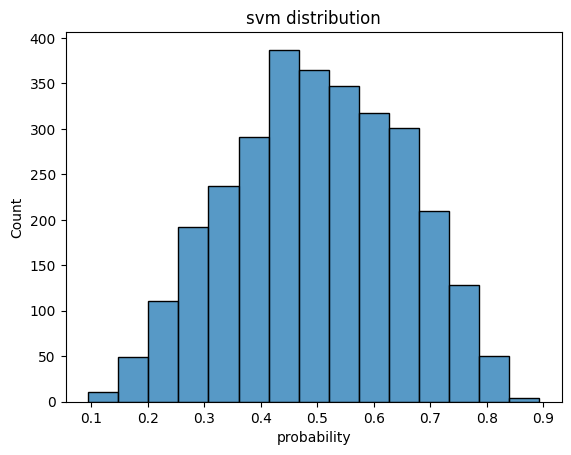

In [31]:
plt.title("svm distribution")
plt.xlabel("probability")
sns.histplot(y_svm, bins=15)
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Первое распределение похоже на $U[0; 1]$, второе на $N(0, 1)$. Такая разница обуславливается разными функциями потерь. В первом случае мы обучаемся на логарифмы вероятностей, что приводит к более равномерному распределению на этих вероятностях. А во втором случае мы максимизируем минимальное расстояние до разделяющей прямой, что приводит к нормальному распределению.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

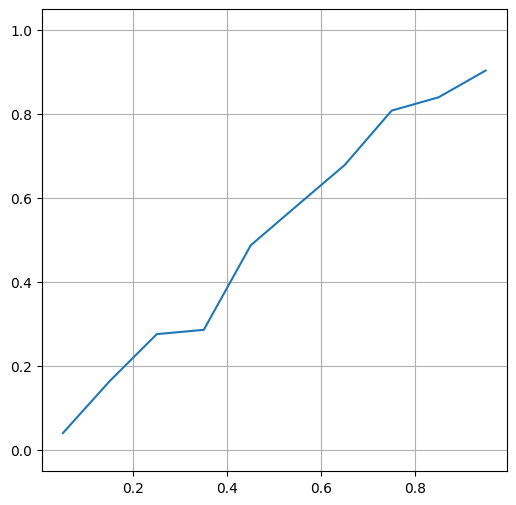

In [32]:
from sklearn.calibration import CalibratedClassifierCV

svm_v2 = CalibratedClassifierCV(svm, cv='prefit')
svm_v2.fit(X_train, y_train)
y_svm_v2 = svm_v2.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_svm_v2)

In [33]:
print(f"svm_v2: log_loss = {log_loss(y_test, y_svm_v2)}, brier_score = {brier_score_loss(y_test, y_svm_v2)}")

svm_v2: log_loss = 0.48617474292200047, brier_score = 0.15870161684478826


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, по сути добились качества логрега

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [34]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [35]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Прочитаем датасет
df = pd.read_csv(path)

categorical = [
    "Marital Status", 
    "Gender",
    "Education",
    "Occupation",
    "Home Owner",
    "Commute Distance",
    "Region"
]
numerical = [
    "Income", 
    "Children",
    "Cars",
    "Age"
]
target = "Purchased Bike"

# Заменим пропуски категориальных переменных
df[categorical] = df[categorical].fillna("UNK")

# Отделим X и y
X = df.iloc[:, 1:-1]
y = np.where(df[target] == 'Yes', 1, 0)

# Разделим на категориальные признаки и числовые
X_numerical = X[numerical]
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [38]:
import time 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

In [39]:
t1 = time.time()
enc = OrdinalEncoder()

X_train_m = enc.fit_transform(X_train)
model = LogisticRegression()
model.fit(X_train_m, y_train)

X_test_m = enc.transform(X_test)
y_pred = model.predict_proba(X_test_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_test, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.5852408495595621
time = 0.006237030029296875


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [40]:
t1 = time.time()
enc = OneHotEncoder()

X_train_m = enc.fit_transform(X_train)
model = LogisticRegression()
model.fit(X_train_m, y_train)

X_test_m = enc.transform(X_test)
y_pred = model.predict_proba(X_test_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_test, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.6662544177340515
time = 0.007004976272583008


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [41]:
t1 = time.time()
X_train_m, X_test_m = X_train.copy(), X_test.copy()
X_train_m[target] = y_train

for category in categorical:
    tmp = X_train_m.groupby(category)[target].mean()
    X_train_m[category] = X_train[category].map(tmp)
    X_test_m[category] = X_test[category].map(tmp)

X_train_m.drop(target, axis=1, inplace=True)

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_test_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_test, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.6575110261581697
time = 0.008533954620361328


In [42]:
model.coef_

array([[2.01994083, 0.37594962, 1.57728483, 0.43782425, 0.04086082,
        2.22593033, 1.75322916]])

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [43]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [44]:
t1 = time.time()
X_train_m, X_test_m = X_train.copy(), X_test.copy()
X_train_m[target] = y_train

for category in categorical:
    tmp = X_train_m.groupby(category)[target].mean()
    X_train_m[category] = X_train[category].map(tmp)
    X_test_m[category] = X_test[category].map(tmp)

    train_n, test_n = X_train_m.shape[0], X_test_m.shape[0]
    X_train_m[category] += np.random.normal(0, 0.5, size=train_n)
    X_test_m[category] = np.random.normal(0, 0.5, size=test_n)

X_train_m.drop(target, axis=1, inplace=True)

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_test_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_test, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.46539211985226975
time = 0.0074329376220703125


In [45]:
model.coef_

array([[ 0.11971518, -0.24528103, -0.17316322,  0.18436511,  0.03657096,
         0.16198509,  0.31796622]])

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Шум - хорошая регуляризация, но эта регуляризация сильно портит модель. То есть мы избежали переобучения (значения весов стали маленькими), но много потеряли в качестве

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [46]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [47]:
t1 = time.time()
X_train_m, X_test_m = X_train.copy(), X_test.copy()
X_train_m[target] = y_train

C = 10
for category in categorical:
    tmp = X_train_m.groupby(category)[target].agg(["sum", "count"])
    tmp["sum"] += C * y_train.mean()
    tmp["count"] += C
    tmp["value"] = tmp["sum"] / tmp["count"]
    
    X_train_m[category] = X_train[category].map(tmp["value"])
    X_test_m[category] = X_test[category].map(tmp["value"])


X_train_m.drop(target, axis=1, inplace=True)

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_test_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_test, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.671269270765978
time = 0.05756711959838867


Получили качество больше чем при OHE

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [48]:
X[target] = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [49]:
quantiles = X_train[numerical].quantile(0.95)
print(quantiles)

Income      120000.0
Children         5.0
Cars             4.0
Age             66.0
Name: 0.95, dtype: float64


In [50]:
X_train_m = X_train.copy()
X_test_m = X_test.copy()

for num_col in numerical:
    X_train_m = X_train_m[X_train_m[num_col] <= quantiles[num_col]]
    X_train_m[num_col] = X_train_m[num_col].fillna(X_train_m[num_col].median())
    X_test_m[num_col] = X_test_m[num_col].fillna(X_train_m[num_col].median())

y_train = X_train_m[target]
y_test = X_test_m[target]

C = 10
for category in categorical:
    tmp = X_train_m.groupby(category)[target].agg(["sum", "count"])
    tmp["sum"] += C * y_train.mean()
    tmp["count"] += C
    tmp["value"] = tmp["sum"] / tmp["count"]
    
    X_train_m[category] = X_train[category].map(tmp["value"])
    X_test_m[category] = X_test[category].map(tmp["value"])


X_train_m.drop(target, axis=1, inplace=True)
X_test_m.drop(target, axis=1, inplace=True)

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_test_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_test, y_pred)}")

auc_pr = 0.6386068797929689


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [51]:
X_train_m = X_train.copy()
X_test_m = X_test.copy()

for num_col in numerical:
    X_train_m = X_train_m[X_train_m[num_col] <= quantiles[num_col]]
    X_train_m[num_col] = X_train_m[num_col].fillna(X_train_m[num_col].median())
    X_test_m[num_col] = X_test_m[num_col].fillna(X_train_m[num_col].median())

y_train = X_train_m[target]
y_test = X_test_m[target]

C = 10
for category in categorical + numerical:
    tmp = X_train_m.groupby(category)[target].agg(["sum", "count"])
    tmp["sum"] += C * y_train.mean()
    tmp["count"] += C
    tmp["value"] = tmp["sum"] / tmp["count"]
    X_train_m[category] = X_train_m[category].map(tmp["value"])
    X_test_m[category] = X_test_m[category].map(tmp["value"])
    X_test_m[category] = X_test_m[category].fillna(X_test_m[category].mode()[0])

X_train_m.drop(target, axis=1, inplace=True)
X_test_m.drop(target, axis=1, inplace=True)

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_test_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_test, y_pred)}")

auc_pr = 0.6571566725524101


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Из плюсов - намного меньшее кол-во переменных, получается более хорошее качество. Из минусов - надо применять методы регуляризации, например добавление случайного шума.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [52]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 23:07:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.1»

adult.data.1            [           <=>      ]   3,79M   455KB/s    за 17s     

2024-12-02 23:08:16 (232 KB/s) - «adult.data.1» сохранён [3974305]



In [53]:
import pandas as pd
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
21705,35,Private,285102,Masters,14,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,0,0,40,Taiwan,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df['income'], train_size=0.75, random_state=777, stratify=df["income"])

In [55]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
14004,60,State-gov,194252,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,3103,0,40,United-States
21060,41,Local-gov,26669,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
7926,18,Private,165754,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States
11552,61,Local-gov,115023,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States
15648,26,Self-emp-not-inc,93806,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder


categorical = [
    'workclass', 
    'education', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'native-country'
]
numeric = [
    'age', 
    'fnlwgt', 
    'education-num', 
    'capital-gain', 
    'capital-loss', 
    'hours-per-week'
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', 'passthrough', numeric)
])

X_train_m = column_transformer.fit_transform(X_train)
X_test_m = column_transformer.transform(X_test)
print(X_train_m.shape[1] - X_train.shape[1])

94


94 новые фичи

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [57]:
model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_test_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_test, y_pred)}")

auc_pr = 0.45599737279715097


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=777)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [63]:
import time

t1 = time.time()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', 'passthrough', numeric)
])

X_train_m = column_transformer.fit_transform(X_train)
X_val_m = column_transformer.transform(X_val)

data = []
for value, name in zip(model.coef_[0], column_transformer.get_feature_names_out()):
    data.append((abs(value), name))
data.sort(key=lambda x: -x[0])
data = [col for _, col in data[:40]]

indexes = []
for d in data:
    ind = None
    for i, el in enumerate(column_transformer.get_feature_names_out()):
        if d == el:
            ind = i
            break
    if ind:
        indexes.append(ind)

X_train_m = X_train_m.toarray()[:, indexes]
X_val_m = X_val_m.toarray()[:, indexes]

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.6679545295053995
time = 0.07976388931274414


Изменилось ли качество? Как?

Да, качество заметно улучшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [198]:
from sklearn.preprocessing import StandardScaler

t1 = time.time()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', StandardScaler(), numeric)
])

X_train_m = column_transformer.fit_transform(X_train)
X_val_m = column_transformer.transform(X_val)
X_test_m = column_transformer.transform(X_test)

model.fit(X_train_m, y_train)

data = []
for value, name in zip(model.coef_[0], column_transformer.get_feature_names_out()):
    data.append((abs(value), name))
data.sort(key=lambda x: -x[0])

data = [col for _, col in data[:40]]
print("\n".join(data))

indexes = []
for d in data:
    ind = None
    for i, el in enumerate(column_transformer.get_feature_names_out()):
        if d == el:
            ind = i
            break
    if ind:
        indexes.append(ind)

X_train_m = X_train_m.toarray()[:, indexes]
X_val_m = X_val_m.toarray()[:, indexes]

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

numeric__capital-gain
ohe__marital-status_ Married-AF-spouse
ohe__native-country_ Columbia
ohe__relationship_ Wife
ohe__marital-status_ Never-married
ohe__occupation_ Priv-house-serv
ohe__occupation_ Farming-fishing
ohe__relationship_ Own-child
ohe__native-country_ Italy
ohe__marital-status_ Separated
ohe__native-country_ Philippines
ohe__native-country_ Cuba
ohe__native-country_ Dominican-Republic
ohe__occupation_ Exec-managerial
ohe__sex_ Female
ohe__native-country_ Taiwan
ohe__native-country_ Canada
ohe__native-country_ Ecuador
ohe__marital-status_ Married-civ-spouse
ohe__occupation_ Protective-serv
ohe__relationship_ Other-relative
ohe__occupation_ Other-service
ohe__native-country_ Jamaica
numeric__education-num
ohe__marital-status_ Divorced
ohe__native-country_ Nicaragua
ohe__occupation_ Tech-support
ohe__occupation_ Prof-specialty
ohe__native-country_ Germany
ohe__native-country_ Guatemala
ohe__workclass_ Federal-gov
ohe__native-country_ France
ohe__marital-status_ Married-spous

Да, качество стало намного лучше

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [203]:
from sklearn.preprocessing import StandardScaler

t1 = time.time()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', "passthrough", numeric)

])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

model.fit(X_train_m, y_train)

data = []
for value, name in zip(model.coef_[0], column_transformer.get_feature_names_out()):
    data.append((abs(value), name))
data.sort(key=lambda x: -x[0])

data = [col for _, col in data[:40]]
print("\n".join(data))

indexes = []
for d in data:
    ind = None
    for i, el in enumerate(column_transformer.get_feature_names_out()):
        if d == el:
            ind = i
            break
    if ind:
        indexes.append(ind)

X_train_m = X_train_m.toarray()[:, indexes]
X_val_m = X_val_m.toarray()[:, indexes]

model = LogisticRegression()
model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

numeric__capital-gain
ohe__marital-status_ Never-married
ohe__sex_ Female
ohe__relationship_ Own-child
ohe__marital-status_ Married-civ-spouse
ohe__occupation_ Priv-house-serv
numeric__hours-per-week
ohe__race_ Black
ohe__native-country_ Columbia
ohe__education_ 7th-8th
ohe__occupation_ Other-service
ohe__education_ HS-grad
numeric__age
numeric__capital-loss
ohe__native-country_ Dominican-Republic
ohe__education_ 10th
ohe__education_ 11th
ohe__race_ White
ohe__marital-status_ Divorced
ohe__occupation_ Farming-fishing
ohe__native-country_ United-States
ohe__education_ Masters
ohe__native-country_ Guatemala
ohe__education_ 9th
ohe__education_ Bachelors
ohe__education_ Preschool
ohe__relationship_ Wife
ohe__education_ Doctorate
ohe__marital-status_ Separated
ohe__workclass_ Self-emp-not-inc
ohe__native-country_ Mexico
ohe__native-country_ Nicaragua
ohe__native-country_ Haiti
ohe__education_ Prof-school
ohe__education_ 5th-6th
ohe__workclass_ Private
ohe__native-country_ ?
numeric__educati

Список самых важных фичей поменялся + выросло качество

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Чем больше модуль значения корреляции, тем важнее признак, поэтому надо оставить топ признаков в наибольшей корреляцией

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [249]:
t1 = time.time()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', "passthrough", numeric)

])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

е1 = time.time()
corr = pd.DataFrame(X_train_m.toarray()).corrwith(y_train)

ind = corr.abs().nlargest(40).index
X_train_m = X_train_m[:, ind]
X_val_m = X_val_m[:, ind]

model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.5956339568121014
time = 0.1279900074005127


/Users/zenman67/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zenman67/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [61]:
t1 = time.time()
X_train_m = X_train.copy()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', "passthrough", numeric)
])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

X_train_m = pd.DataFrame(X_train_m.toarray(), columns=column_transformer.get_feature_names_out())
X_val_m = pd.DataFrame(X_val_m.toarray(), columns=column_transformer.get_feature_names_out())

X_train_m[target] = y_train

ts = []
for feature in X_train_m.columns[:-1]:
    stat = X_train_m.groupby(target)[feature].agg(['mean', 'count', 'std'])
    top = np.abs(stat['mean'][1] - stat['mean'][0])
    bottom_top = (stat['count'][1] * stat['std'][1] ** 2 + stat['count'][0] * stat['std'][0] ** 2)
    bottom_bottom = stat['count'][0] + stat['count'][1]
    ts.append(top / np.sqrt(bottom_top / bottom_bottom))

X_train_m.drop(target, axis=1, inplace=True)
coefs = pd.DataFrame({'ts' : ts, 'name' : column_transformer.get_feature_names_out()})

X_train_m = X_train_m[coefs.sort_values('ts', ascending=False).iloc[:40, :]['name']]
X_val_m = X_val_m[coefs.sort_values('ts', ascending=False).iloc[:40, :]['name']]

model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.6667774869745879
time = 0.2410290241241455


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [64]:
t1 = time.time()

k, m = 50, 3

X_train_m = X_train.copy()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', "passthrough", numeric)
])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

X_train_m = pd.DataFrame(X_train_m.toarray(), columns=column_transformer.get_feature_names_out())
X_val_m = pd.DataFrame(X_val_m.toarray(), columns=column_transformer.get_feature_names_out())

arr = X_train_m.columns
while arr.shape[0] > k:
    model.fit(X_train_m, y_train)
    coefs = pd.DataFrame({'x' : np.abs(model.coef_.reshape(-1, )), 'name' : arr})
    dropped = coefs.sort_values('x')['name'].iloc[:min(arr.shape[0] - k, m)]
    X_train_m.drop(dropped, axis=1, inplace=True)
    arr = X_train_m.columns


model.fit(X_train_m, y_train)
X_val_m = X_val_m[X_train_m.columns]
y_pred = model.predict_proba(X_val_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.7590453695200876
time = 1.210221767425537


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [65]:
t1 = time.time()

k, m = 50, 3

X_train_m = X_train.copy()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', "passthrough", numeric)
])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

X_train_m = pd.DataFrame(X_train_m.toarray(), columns=column_transformer.get_feature_names_out())
X_val_m = pd.DataFrame(X_val_m.toarray(), columns=column_transformer.get_feature_names_out())

X_train_m_tmp = X_train_m.copy()
columns_to_take = []

while len(columns_to_take) < k:
    model.fit(X_train_m_tmp, y_train)
    coefs = pd.DataFrame({'x' : np.abs(model.coef_.reshape(-1, )), 'name' : X_train_m_tmp.columns})
    taken = coefs.sort_values('x', ascending=False)['name'].iloc[:min(k - len(columns_to_take), m)]
    X_train_m_tmp.drop(taken, axis=1, inplace=True)
    columns_to_take.extend(taken)

X_train_m = X_train_m[columns_to_take]
X_val_m = X_val_m[columns_to_take]

model.fit(X_train_m, y_train)
X_val_m = X_val_m[X_train_m.columns]
y_pred = model.predict_proba(X_val_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

auc_pr = 0.7583802602758773
time = 0.8700149059295654


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Встроенные методы обладают хорошей скоростью вычислений и в комбинации со стандартизацией позволяют получить высокое качество. Можно сказать, что это - золотая середина. Методы фильтрации обладают понятной интерпретацией и быстро работают, но не учитывают взаимосвязь признаков между собой, поэтому выбивают плохое качество. Методы обёртки обладают наибольшим временем работы, зато позволяют выбить наибольшее качество

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

In [259]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [260]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [261]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [342]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score


def cross_validate(
    X,
    y,
    model,
    column_transformer,
    threshold=0.5,
    n_splits=5,
    client_money=10,
    random_state=None,
    shuffle=False,
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)

        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)

        cm = confusion_matrix(y_test, y_pred)

        if isinstance(client_money, int):
            client_money = cm[1, 1] * client_money
        else:
            client_money = cm[1, 1] * np.random.uniform(0, 20, cm[1, 1]).mean()

        metric_dict = {
            "pr_auc": average_precision_score(y_test, y_pred_proba),
            "roc_auc": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred),
            "recall" : recall_score(y_test, y_pred),
            "profit": client_money - 2 * (cm[1, 1] + cm[0, 1]),
            "income": client_money,
        }

        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [337]:
categorical = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]

numeric = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed"
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric', StandardScaler(), numeric)
])

df = cross_validate(X, y, LogisticRegression(), column_transformer, random_state=42, shuffle=True)

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

В среднем заработаем:

In [309]:
df["profit"].mean()

1416.0251397652337

Стд профита:

In [310]:
df["profit"].std()

83.05929116918556

Работникам надо заплатить:

In [311]:
(df["income"] - df["profit"]).mean()

640.0

График пропорциональности

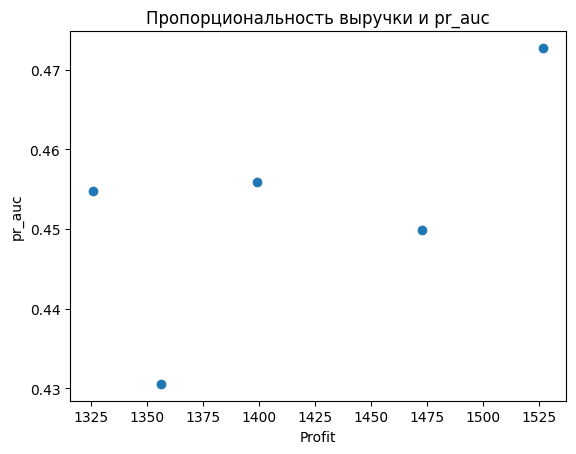

In [312]:
plt.title("Пропорциональность выручки и pr_auc")
plt.xlabel("Profit")
plt.ylabel("pr_auc")
plt.scatter(df["profit"], df["pr_auc"])
plt.show()

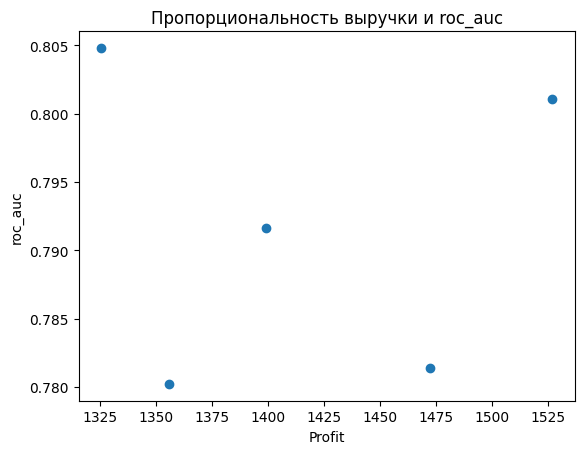

In [313]:
plt.title("Пропорциональность выручки и roc_auc")
plt.xlabel("Profit")
plt.ylabel("roc_auc")
plt.scatter(df["profit"], df["roc_auc"])
plt.show()

Не пропорциональна

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [322]:
df = cross_validate(X, y, LogisticRegression(), column_transformer, client_money="random", random_state=42, shuffle=True)

In [323]:
df["profit"].mean()

1448.3904858482672

In [324]:
df["profit"].std()

195.57719057941947

In [325]:
(df["income"] - df["profit"]).mean()

640.0

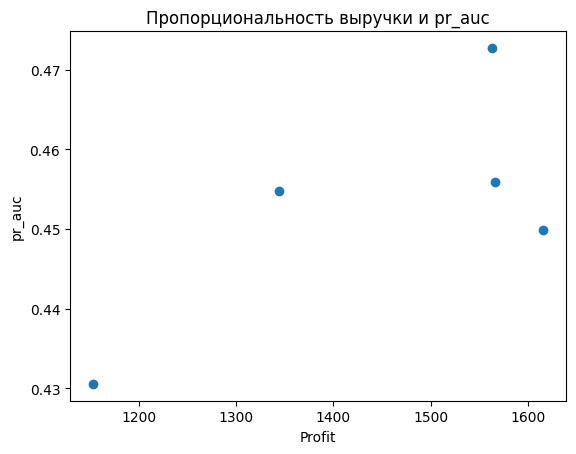

In [326]:
plt.title("Пропорциональность выручки и pr_auc")
plt.xlabel("Profit")
plt.ylabel("pr_auc")
plt.scatter(df["profit"], df["pr_auc"])
plt.show()

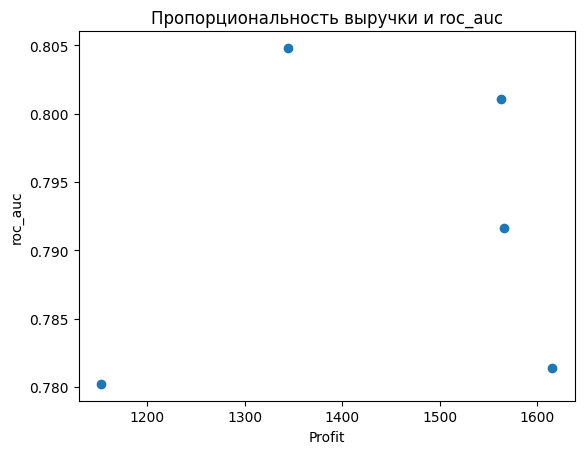

In [327]:
plt.title("Пропорциональность выручки и roc_auc")
plt.xlabel("Profit")
plt.ylabel("roc_auc")
plt.scatter(df["profit"], df["roc_auc"])
plt.show()

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


С = 10.0


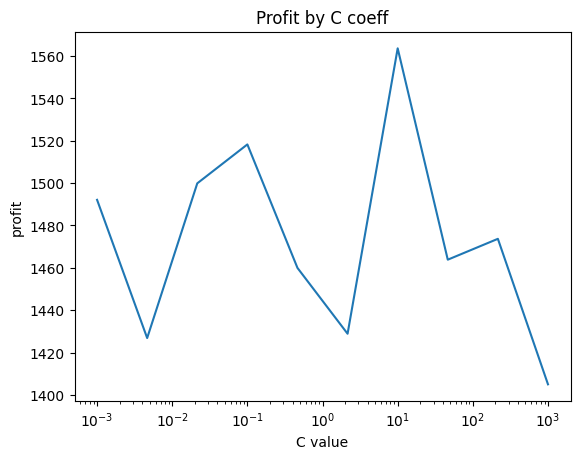

In [343]:
from tqdm import tqdm 

best_C, best_profit, best_metrics = None, -1, None
history = []

vals = np.logspace(-3, 3, 10)
for C in tqdm(vals):
    metrics = cross_validate(X, y, LogisticRegression(C=C), column_transformer, client_money="random", random_state=42, shuffle=True)
    mean_profit = metrics['profit'].mean()
    history.append(mean_profit)
    if mean_profit > best_profit:
        best_profit, best_C, best_metrics = mean_profit, C, metrics

print(f"С = {best_C}")
plt.plot(vals, history)

plt.title('Profit by C coeff')
plt.xlabel("C value")
plt.ylabel("profit")
plt.xscale('log')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Нет, значения С выходят очень шумными - иногда могут быть меньше 1, а иногда равны примерно 200
Вероятно, это связано со слишком маленьким кол-вом клиентов, для которых мы предсказали 1 и настоящая метка = 1

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В данном случае важнее recall, посколько людей, которые соглашаются на предложения сильно меньше тех, кто не соглашается. Поэтому лучше лишний раз предсказать 1, чем предсказать 0 и потерять клиента



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [350]:
best_threshold, best_profit, best_metrics = None, -1, None
history = []

for threshold in np.arange(0, 1, 0.01):
    metrics = cross_validate(X, y, LogisticRegression(), column_transformer, threshold, client_money="random", random_state=42, shuffle=True)
    mean_profit = metrics['profit'].mean()
    history.append(mean_profit)

    if mean_profit > best_profit:
        best_profit, best_threshold, best_metrics = mean_profit, threshold, metrics

/var/folders/5l/dflggy6x7l7f_rn67rd7dz2w0000gn/T/ipykernel_92188/1730920314.py:36: RuntimeWarning: Mean of empty slice.
  client_money = cm[1, 1] * np.random.uniform(0, 20, cm[1, 1]).mean()
/Users/zenman67/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zenman67/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/5l/dflggy6x7l7f_rn67rd7dz2w0000gn/T/ipykernel_92188/1730920314.py:36: RuntimeWarning: Mean of empty slice.
  client_money = cm[1, 1] * np.random.uniform(0, 20, cm[1, 1]).mean()
/Users/zenman67/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: inv

In [351]:
print(f"best threshold = {best_threshold}")

best threshold = 0.19


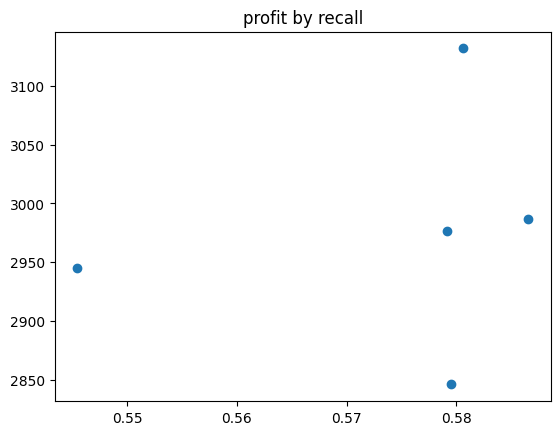

In [352]:
plt.scatter(best_metrics['recall'], best_metrics['profit'])
plt.title("profit by recall")
plt.show()

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




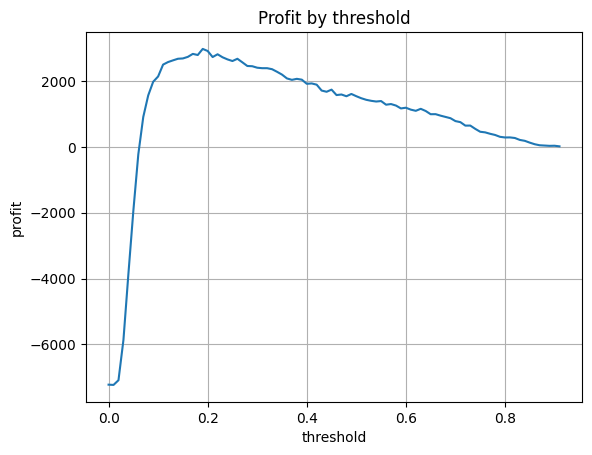

In [353]:
plt.plot(np.arange(0, 1, 0.01), history)
plt.title('Profit by threshold')
plt.xlabel("threshold")
plt.ylabel("profit")
plt.grid()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Да, видно что threshold всегда находится в окрестности 0.2, что как раз соответствует низкому recall

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [355]:
metrics_best = cross_validate(X, y, LogisticRegression(C=best_C), column_transformer, best_threshold, client_money="random", random_state=42, shuffle=True)
print(f"Best: {metrics_best['profit'].mean()}, {metrics_best['profit'].std()}")
metrics_usual = cross_validate(X, y, LogisticRegression(), column_transformer, random_state=42, shuffle=True)
print(f"Usual: {metrics_usual['profit'].mean()}, {metrics_usual['profit'].std()}")

Best: 2818.7667406540727, 211.00683557708197
Usual: 1519.1706307486347, 105.42002300623722


In [360]:
import scipy.stats as stats

stats.ttest_rel(metrics_usual['profit'], metrics_best['profit'])

TtestResult(statistic=-16.702137165872543, pvalue=7.529304675529815e-05, df=4)

Получаем pvalue < 0.05, то есть модель получилась стат. значимо лучше

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ творог со сметаной и манго